<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Pytorch_lightning_Falsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia Classification Challenge 

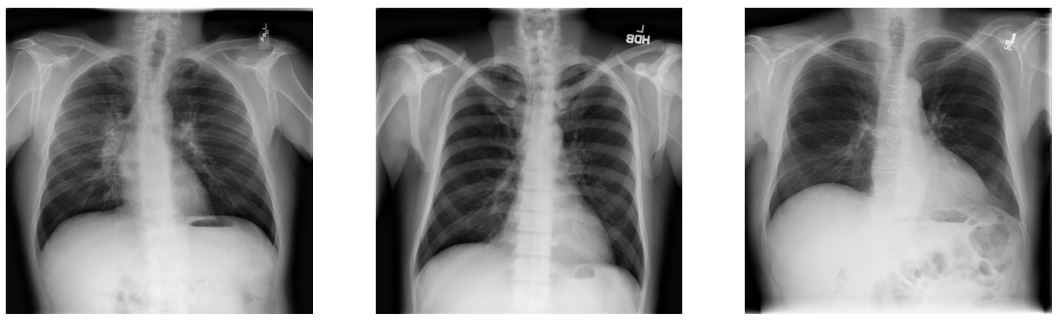

In [64]:
%%capture
!pip install pytorch-lightning

In [65]:
!pip install torchtext==0.8.0 torch==1.7.1 
!pip install lightning-flash -U

Requirement already up-to-date: lightning-flash in /usr/local/lib/python3.7/dist-packages (0.2.3)


## Import Pytorch Lightning Packages

In [66]:
from  torchmetrics import Accuracy,F1,FBeta

In [67]:
# pytorch lightning
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pl_bolts.models.self_supervised import SwAV
#pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader,random_split
from torchvision import models,transforms,datasets
#
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##Download Sample Images

In [68]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

## Import Data Science Libraries

In [69]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import os # OS module in Python provides a way of using operating system dependent functionality
import shutil
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set

In [6]:
image_folder = os.listdir("/content/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/content/pneumonia_dataset/train",folder)):
    filename.append(image_name)
    label.append(folder)

In [7]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

,filename,label
0,CXR_train_1184.png,normal
1,CXR_train_447.png,normal
2,CXR_train_1746.png,normal
3,CXR_train_549.png,normal
4,CXR_train_558.png,normal


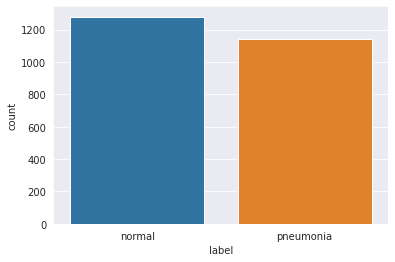

In [10]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

In [16]:
label_dict = {'normal': 0, 'pneumonia': 1}
train_df['label'] = train_df['label'].map(label_dict)
train_df.head()

,filename,label
0,CXR_train_1184.png,0
1,CXR_train_447.png,0
2,CXR_train_1746.png,0
3,CXR_train_549.png,0
4,CXR_train_558.png,0


In [11]:
!mkdir "/content/content/pneumonia_dataset/val"
!mkdir "/content/content/pneumonia_dataset/val/normal"
!mkdir "/content/content/pneumonia_dataset/val/pneumonia"

In [26]:
import os
os.listdir("/content/content/pneumonia_dataset")

['sample_submission.csv', 'val', 'train', 'test.csv', 'test']

In [17]:
train_data,val_data= train_test_split(train_df,test_size=0.1,stratify=train_df['label'],random_state=42)

In [18]:
print(train_data.shape,val_data.shape)

(2182, 2) (243, 2)


In [21]:
import shutil
p = "/content/content/pneumonia_dataset/val/"
path = "/content/content/pneumonia_dataset/train/"
for items in val_data.values.tolist():
  
  if items[1] == 0:
    src = path+"normal/"+items[0]
    dest = p+"normal"
  else:
    src = path+"pneumonia/"+items[0]
    dest = p+"pneumonia"
  shutil.move(src,dest)

In [27]:
os.listdir("/content/content/pneumonia_dataset/val/")

['normal', 'pneumonia']

In [41]:
import flash
from flash import download_data
from flash.vision import ImageClassificationData, ImageClassifier
from flash.core.finetuning import FlashBaseFinetuning
print(flash.__version__)#0.2.1
#
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import pytorch_lightning as pl
print(pl.__version__)#1.2.0rc0

0.2.3
1.2.6


In [70]:
datamodule = ImageClassificationData.from_folders(
    train_folder = "/content/content/pneumonia_dataset/train/",
    valid_folder = "/content/content/pneumonia_dataset/val/",
    predict_folder = "/content/content/pneumonia_dataset/test"
)

In [71]:
datamodule

In [72]:
datamodule.num_classes #returns the number of unique labels or classes

2

In [73]:
model = ImageClassifier(backbone="resnet34", num_classes=datamodule.num_classes,learning_rate=0.001,optimizer=optim.Adam,metrics=[torchmetrics.FBeta(num_classes=2),torchmetrics.Accuracy()])

In [74]:
model.children

<bound method Module.children of ImageClassifier(
  (metrics): ModuleDict(
    (fbeta): FBeta()
    (accuracy): Accuracy()
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [76]:
trainer = flash.Trainer(max_epochs=25,gpus=1,progress_bar_refresh_rate = 20,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [55]:
class FeatureExtractorFreezeUnfreeze(FlashBaseFinetuning):
  def __init__(self,model,unfreeze_at_epoch: int = 5, train_bn: bool = True):
    # this will set self.attr_names as ["feature_extractor"]
    super().__init__("feature_extractor", train_bn)
    self._unfreeze_at_epoch = unfreeze_at_epoch
    self.model = model
    _layers = list(model.children())[:-1]
    self.feature_extractor = nn.Sequential(*_layers)
    def finetune_function(self, feature_extractor, current_epoch, optimizer, opt_idx):
      # unfreeze any module you want by overriding this function
      # When ``current_epoch`` is 5, feature_extractor will start to be trained.
      if current_epoch == self._unfreeze_at_epoch:
        self.unfreeze_and_add_param_group(
                module=self.feature_extractor,
                optimizer=optimizer,
                train_bn=True,
                )


In [77]:
trainer.finetune(model, datamodule=datamodule,strategy='no_freeze')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | metrics  | ModuleDict | 0     
1 | backbone | Sequential | 21.3 M
2 | head     | Sequential | 1.0 K 
----------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/flash/vision/classification/model.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.head(x))


1

In [78]:
trainer.fit(model,datamodule=datamodule,)                                                                  

/usr/local/lib/python3.7/dist-packages/flash/core/trainer.py:52: UserWarning: Warning: You are calling fit(), but your trainer is using a fine-tuning callback
  warnings.warn("Warning: You are calling fit(), but your trainer is using a fine-tuning callback")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | metrics  | ModuleDict | 0     
1 | backbone | Sequential | 21.3 M
2 | head     | Sequential | 1.0 K 
----------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/flash/vision/classification/model.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.head(x))


1

In [79]:
trainer.save_checkpoint("image_classification_model.pt")

In [89]:
model = ImageClassifier.load_from_checkpoint("/content/image_classification_model.pt")

In [91]:
test =pd.read_csv("/content/content/pneumonia_dataset/test.csv")

In [92]:
test.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


In [83]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/flash/core/trainer.py:52: UserWarning: Warning: You are calling fit(), but your trainer is using a fine-tuning callback
  warnings.warn("Warning: You are calling fit(), but your trainer is using a fine-tuning callback")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1

In [93]:
test['filename'] = "/content/content/pneumonia_dataset/test/" +test["filename"]
test.head()

,filename
0,/content/content/pneumonia_dataset/test/CXR_te...
1,/content/content/pneumonia_dataset/test/CXR_te...
2,/content/content/pneumonia_dataset/test/CXR_te...
3,/content/content/pneumonia_dataset/test/CXR_te...
4,/content/content/pneumonia_dataset/test/CXR_te...


/usr/local/lib/python3.7/dist-packages/flash/vision/classification/model.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(self.head(x))
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


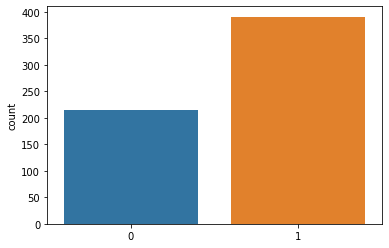

In [94]:
predictions = model.predict(test.filename.values.tolist())
import seaborn as sns
sns.countplot(predictions)

In [96]:
preds = []
for i in predictions:
  if i == 0:
    preds.append('normal')
  else:
    preds.append("pneumonia")

In [97]:
res = pd.DataFrame({'label': preds}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission_flash.csv", index = False)
# To download the csv file locally
from google.colab import files
files.download('submission_flash.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://lightning-flash.readthedocs.io/_/downloads/en/latest/pdf/

**Submission successful! Your score is 56.04915626217846.**